# Conditional Generative Adversarial Nets

TensorFlow implementation of [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784). The concept is from the paper but this notebook implements a different architecture which is using Convolutional and de-Convolutional Neural Networks.

We also visualize the training process and the final result at the end of this notebook.

In [1]:
import tensorflow as tf

# Hyper-parameters

In [2]:
# for input
batch_size = 100
h_size, w_size, c_size = 28, 28, 1
y_size = 10
z_size = 100
half_size, quarter_size = h_size//2, h_size//4

# for discriminator
D_conv1_filter_size = 5
D_conv1_channel_size = 10
D_conv2_filter_size = 5
D_conv2_channel_size = 64
D_fc1_incoming_size = D_conv2_channel_size * quarter_size * quarter_size
D_fc1_size = 1024
D_output_size = 1

# for generator
G_deconv1_filter_size = 5
G_deconv1_channel_size = 128
G_deconv2_filter_size = 5
G_deconv2_channel_size = 128
G_fc1_size = 1024
G_fc2_size = G_deconv1_channel_size * quarter_size * quarter_size

# Variables

In [3]:
def make_variable(shape):
    return tf.Variable(tf.random_normal(shape=shape, stddev=0.02))

In [4]:
D_weights = {
    'conv1' : make_variable((D_conv1_filter_size, D_conv1_filter_size, c_size + y_size, D_conv1_channel_size)),
    'conv2' : make_variable((D_conv2_filter_size, D_conv2_filter_size, D_conv1_channel_size, D_conv2_channel_size)),
    'fc1' : make_variable((D_fc1_incoming_size, D_fc1_size)),
    'output' : make_variable((D_fc1_size, D_output_size)),
    
    'conv1_bias' : tf.Variable(tf.zeros(shape=(D_conv1_channel_size))),
    'conv2_bias' : tf.Variable(tf.zeros(shape=(D_conv2_channel_size))),
    'fc1_bias' : tf.Variable(tf.zeros(shape=(D_fc1_size))),
    'output_bias' : tf.Variable(tf.zeros(shape=(D_output_size))),
}

G_weights = {
    'fc1' : make_variable((z_size + y_size, G_fc1_size)),
    'fc2' : make_variable((G_fc1_size, G_fc2_size)),
    'deconv1' : make_variable((G_deconv1_filter_size, G_deconv1_filter_size, G_deconv2_channel_size, G_deconv1_channel_size)),
    'deconv2' : make_variable((G_deconv2_filter_size, G_deconv2_filter_size, c_size, G_deconv2_channel_size)),
    
    'fc1_bias' : tf.Variable(tf.zeros(shape=(G_fc1_size))),
    'fc2_bias' : tf.Variable(tf.zeros(shape=(G_fc2_size))),
    'deconv1_bias' : tf.Variable(tf.zeros(shape=(G_deconv2_channel_size))),
    'deconv2_bias' : tf.Variable(tf.zeros(shape=(c_size))),
}

In [5]:
x = tf.placeholder(tf.float32, shape=(None, h_size, w_size, c_size))
y = tf.placeholder(tf.float32, shape=(None, y_size))
z = tf.placeholder(tf.float32, shape=(None, z_size))

In [6]:
# for batch normalization
is_training = tf.placeholder(tf.bool, [])

# Model

In [7]:
def batch_norm(X, scope='scope', reuse=False):
    return tf.contrib.layers.batch_norm(X, decay=0.9, scale=True, updates_collections=None, is_training=is_training,
                                        reuse=reuse, scope=scope)

def fully_connected(X, W, b):
    return tf.matmul(X, W) + b

def convolution(X, W, b):
    conv = tf.nn.conv2d(X, W, strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.bias_add(conv, b)
    return conv

def deconvolution(X, W, b, output_shape):
    deconv = tf.nn.conv2d_transpose(X, W, output_shape=output_shape, strides=[1,2,2,1], padding='SAME')
    deconv = tf.nn.bias_add(deconv, b)
    return deconv

In [8]:
def D(x, y, w=D_weights, reuse=False):
    # x shape : (batch_size, 28, 28, 1)
    # y shape : (batch_size, 10)
    
    y_reshaped = tf.reshape(y, shape=(batch_size, 1, 1, y_size)) * tf.ones_like(x)
    xy = tf.concat(3, [x, y_reshaped])
    
    conv1 = convolution(xy, w['conv1'], w['conv1_bias'])
    conv1 = tf.nn.relu(conv1)
    
    conv2 = convolution(conv1, w['conv2'], w['conv2_bias'])
    conv2 = batch_norm(conv2, scope='D_conv2_bn', reuse=reuse)
    conv2 = tf.nn.relu(conv2)
    
    conv_flattened = tf.reshape(conv2, shape=(batch_size, -1))
    
    fc1 = fully_connected(conv_flattened, w['fc1'], w['fc1_bias'])
    fc1 = batch_norm(fc1, scope='D_fc1_bn', reuse=reuse)
    fc1 = tf.nn.relu(fc1)
    
    fc2 = fully_connected(fc1, w['output'], w['output_bias'])
    
    return tf.nn.sigmoid(fc2)

In [9]:
def G(z, y, w=G_weights, reuse=False):
    # z shape : (batch_size, 100)
    # y shape : (batch_size, 10)
    
    zy = tf.concat(1, [z, y])
    fc1 = fully_connected(zy, w['fc1'], w['fc1_bias'])
    fc1 = batch_norm(fc1, scope='G_fc1_bn', reuse=reuse)
    fc1 = tf.nn.relu(fc1)
    
    fc2 = fully_connected(fc1, w['fc2'], w['fc2_bias'])
    fc2 = batch_norm(fc2, scope='G_fc2_bn', reuse=reuse)
    fc2 = tf.nn.relu(fc2)
    
    fc_reshaped = tf.reshape(fc2, shape=(batch_size, 7, 7, 128))
    
    deconv1 = deconvolution(fc_reshaped, w['deconv1'], w['deconv1_bias'], 
                            output_shape=(batch_size, h_size//2, w_size//2, 128))
    deconv1 = batch_norm(deconv1, scope='G_deconv1_bn', reuse=reuse)
    deconv1 = tf.nn.relu(deconv1)
    
    deconv2 = deconvolution(deconv1, w['deconv2'], w['deconv2_bias'], 
                           output_shape=(batch_size, h_size, w_size, 1))
    return tf.nn.sigmoid(deconv2)

In [10]:
D_prob_real_x = D(x, y)
fake_x = G(z, y)
D_prob_fake_x = D(fake_x, y, reuse=True)

In [11]:
fake_images = G(z, y, reuse=True) # for sampling

# Objective

In [12]:
D_objective = -tf.reduce_mean(tf.log(D_prob_real_x) + tf.log(1 - D_prob_fake_x))
G_objective = -tf.reduce_mean(tf.log(D_prob_fake_x))

# Optimizer

In [13]:
D_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(D_objective, var_list=D_weights.values())
G_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(G_objective, var_list=G_weights.values())

# Training

In [14]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets

In [15]:
mnist = read_data_sets('/tmp/data/', one_hot=True, reshape=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [16]:
session = tf.InteractiveSession()

In [17]:
tf.global_variables_initializer().run()
iteration = 0

In [18]:
from module.helper import generate_z, generate_y

In [19]:
sampled_z = generate_z(batch_size, z_size)
sampled_y = generate_y(batch_size)

In [20]:
# for tracking
samples = []
p_real_list = []
p_fake_list = []

In [21]:
for _ in range(500):
    train_x, train_y = mnist.train.next_batch(batch_size)
    generated_z = generate_z(batch_size, z_size)
    
    D_optimizer.run(feed_dict={x:train_x, y:train_y, z:generated_z, is_training:True})
    G_optimizer.run(feed_dict={y:train_y, z:generated_z, is_training:True})
    
    p_real = D_prob_real_x.eval(feed_dict={x:train_x, y:train_y, z:generated_z, is_training:False}).mean()
    p_fake = D_prob_fake_x.eval(feed_dict={x:train_x, y:train_y, z:generated_z, is_training:False}).mean()
    p_real_list.append(p_real)
    p_fake_list.append(p_fake)

    iteration += 1
    
    if iteration % 50 == 0:
        print("iteration {i:<4d}  D objective: {D_obj:<.6f}  G objective: {G_obj:<.6f}  D(x,y): {p_real:<.6f}  D(G(z,y),y): {p_fake:<.6f}".format(
            i=iteration,
            D_obj=D_objective.eval(feed_dict={x:train_x, y:train_y, z:generated_z, is_training:False}),
            G_obj=G_objective.eval(feed_dict={y:train_y, z:generated_z, is_training:False}),
            p_real=p_real,
            p_fake=p_fake))

        samples.append(fake_images.eval(feed_dict={z:sampled_z, y:sampled_y, is_training:False})[:10])

iteration 50    D objective: 1.161250  G objective: 0.956420  D(x,y): 0.535623  D(G(z,y),y): 0.397769
iteration 100   D objective: 1.300928  G objective: 0.863945  D(x,y): 0.572052  D(G(z,y),y): 0.457226
iteration 150   D objective: 1.097969  G objective: 1.049955  D(x,y): 0.539915  D(G(z,y),y): 0.360346
iteration 200   D objective: 1.113207  G objective: 0.772682  D(x,y): 0.635738  D(G(z,y),y): 0.469987
iteration 250   D objective: 1.220852  G objective: 0.756945  D(x,y): 0.613819  D(G(z,y),y): 0.487016
iteration 300   D objective: 1.177274  G objective: 0.691139  D(x,y): 0.637255  D(G(z,y),y): 0.506852
iteration 350   D objective: 1.171210  G objective: 0.825788  D(x,y): 0.572541  D(G(z,y),y): 0.445962
iteration 400   D objective: 1.213668  G objective: 0.796205  D(x,y): 0.561660  D(G(z,y),y): 0.458189
iteration 450   D objective: 1.164118  G objective: 0.783446  D(x,y): 0.594342  D(G(z,y),y): 0.462861
iteration 500   D objective: 1.180951  G objective: 0.771784  D(x,y): 0.590350  D(

# Visualization of Training 

In [27]:
%matplotlib inline
from module.helper import interactive_plot, square_plot
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

In [29]:
iplot(interactive_plot(p_real_list, p_fake_list, data1_name='D(x,y)', data2_name='D(G(z,y),y)'))

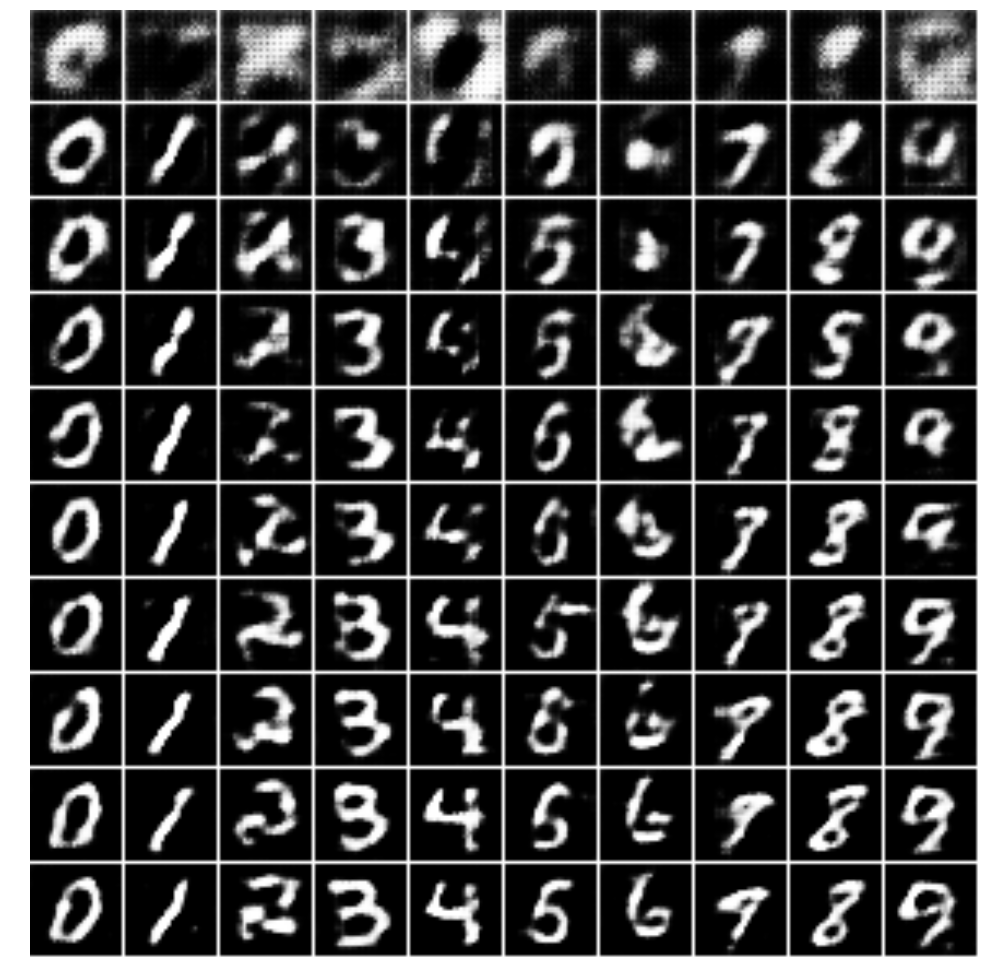

In [30]:
square_plot(samples)

# Result

In [31]:
generated_z = generate_z(batch_size, z_size)
generated_y = generate_y(batch_size)
generated_images = fake_images.eval(feed_dict={z:generated_z, y:generated_y, is_training:False})

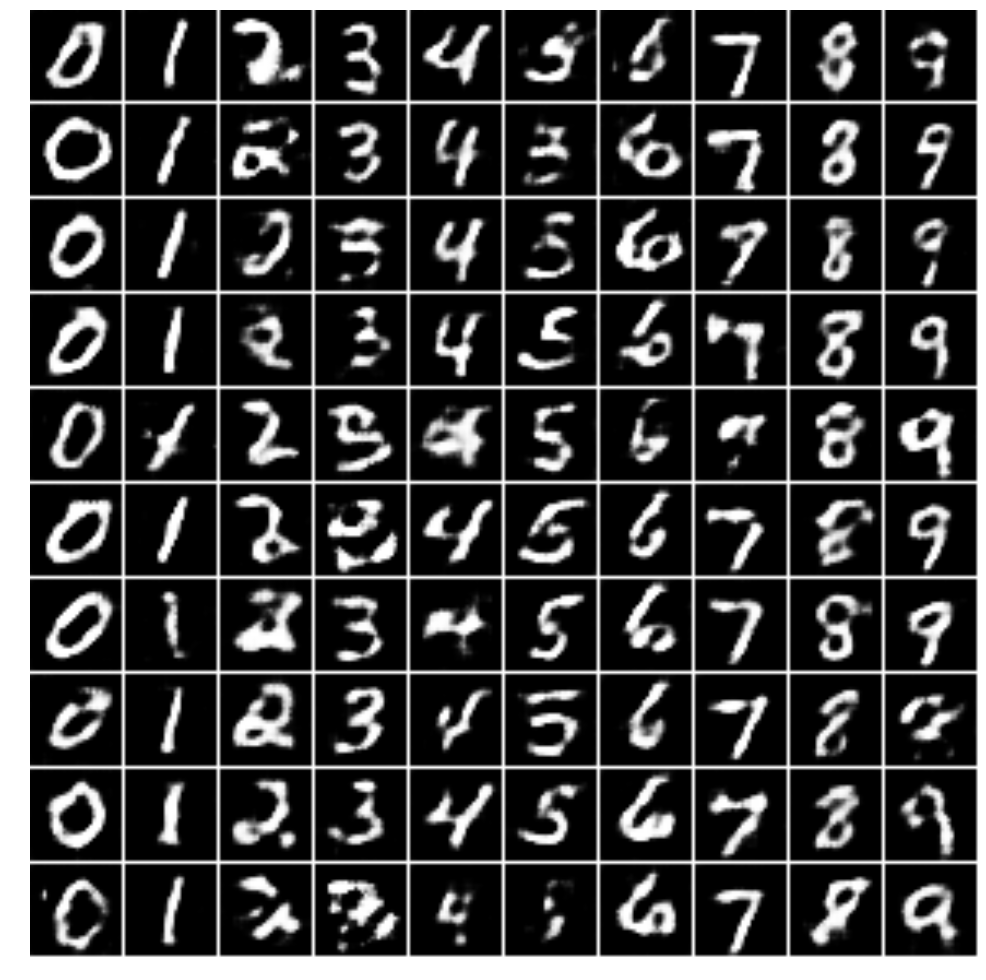

In [32]:
square_plot(generated_images)